Note: this is based on the work by "The Lazy Programmer" on binary text classification (spam detection) - see https://colab.research.google.com/drive/10sj51zHi9K0RocOT48nCOpKNcZxXflj9#forceEdit=true&sandboxMode=true&scrollTo=sFnA0eiI-2BM

You can find more info on the application of CNNs to text classification here: https://youtu.be/8YsZXTpFRO0

In this notebook we do not use word embeddings like word2vec or GloVe but instead use a standard Keras Embedding layer to learn the weights. 

Please note: this Jupyter notebook is meant to be run on Google Colab with a GPU and High RAM runtime. 


In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## Set Up

### Imports

In [1]:
import pandas as pd
import numpy as np
import random
import nltk
nltk.download('punkt')
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# For examining results
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sn

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Formatting

In [0]:
# This just makes formatting easier
pd.options.display.max_rows = 60
pd.options.display.min_rows = None
pd.set_option('max_colwidth', 150)

### Common Functions

In [0]:
def plot_training_history(history, model, test_data, test_labels, eval_images=False):
    figure = plt.figure()

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')
    plt.tight_layout()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')
    plt.tight_layout()

    figure.tight_layout()
    plt.show()
    
    loss, accuracy  = model.evaluate(test_data, test_labels, verbose=False)
        
    print(f'Test loss: {loss:.3}')
    print(f'Test accuracy: {accuracy:.3}')

## Load and Prepare Data

### Loading Data

In [0]:
dataset = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Octopus2/JIRA_OPEN_DATA_ZOOKEEPER.csv")

### Data Preparation

In [0]:
df = dataset[["title", "description", "priority"]]
df['features'] = df['title'] + " " + df['description']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
random.seed(1)

Remove all the "junk" in the features 

In [0]:
df1 = df.copy()
df1.features = df1.features.str.replace(r"[\n\r\t]+", " ")
df1.features = df1.features.str.replace(r"([a-zA-Z0-9_\-\.]+)@([a-zA-Z0-9_\-\.]+)\.([a-zA-Z]{2,5})", " ")
df1.features = df1.features.str.replace(r"((http[s]?|ftp):\/)?\/?([^:\/\s]+)((\/\w+)*\/)([\w\-\.]+[^#?\s]+)(.*)?(#[\w\-]+)?", " ")
df1.features = df1.features.str.replace(r"([0-9]+)", " ")

In [0]:
df1['features']

0                       Quota is not correctly rehydrated on snapshot reload traverseNode in DataTree will never actually traverse the limit nodes properly.
1        bookkeeper create calls completion too many times when calling the asynchronous version of create, the completion routine is called more than once.
2                                                                                                                         test -e not available on solaris  
3                                                                             CnxManagerTest failed on hudson It timed out according to the console output: 
4                                                                                                              FLE test. fast leader election test failing .
5      In two places, the wrong class is specified for the logger Copy and paste strikes again.  In two logger instantiations, the wrong class is passed ...
6                                                         

(array([ 77.,   0., 224.,   0.,   0.,  70.,   0.,  63.,   0.,  13.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

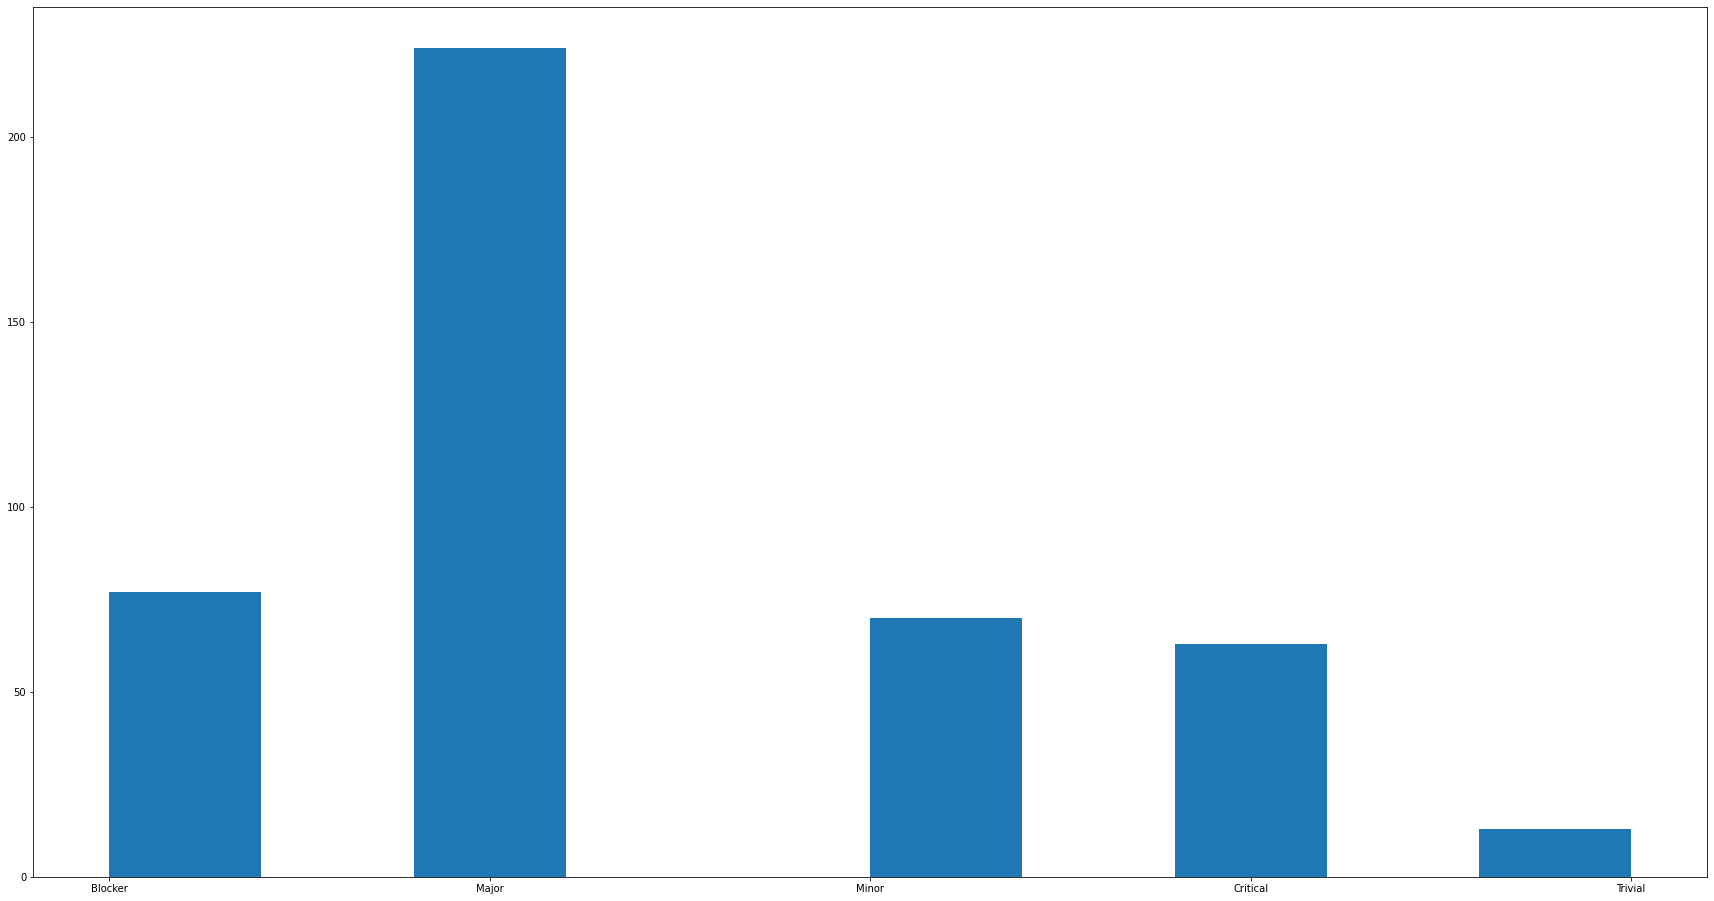

In [0]:
plt.figure(figsize=(30,16))
plt.hist(df1.priority)

In [0]:
# create binary labels
df1['b_labels'] = df1['priority'].map({'Trivial': 0, 'Minor': 1, 'Major': 2, 'Blocker': 3, 'Critical': 4})
Y = df1['b_labels'].values

In [0]:
df1.describe()

,b_labels
count,447.000000
mean,2.239374
std,0.976618
min,0.000000
25%,2.000000
50%,2.000000
75%,3.000000
max,4.000000


In [0]:
# split up the data
df_train, df_test, Ytrain, Ytest = train_test_split(df['features'], Y, test_size=0.3)

In [0]:
# Convert sentences to sequences
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

In [0]:
print(sequences_train)

[[2, 26, 288, 1130, 24, 154, 23, 5, 94, 4, 2, 194, 108, 1, 2, 26, 28, 288, 2090, 1447, 24, 154, 194, 108, 23, 5, 60, 94], [409, 41, 1448, 1449, 33, 145, 1131, 41, 1448, 5, 1449, 2091, 229, 139, 34, 1, 941, 2092, 1, 1131, 30, 1, 1131, 6, 942, 146, 21, 230, 73, 634, 120, 10, 1, 1132, 10, 1, 2093, 714, 4, 2094, 943, 3, 1, 1133, 409], [231, 180, 715, 289, 37, 1450, 89, 557, 1134, 229, 1, 715, 289, 23, 231, 1451, 492, 715, 7, 139, 320, 410, 1452, 52, 21, 188, 3, 302, 19, 21, 37, 944, 1, 211, 557, 1134, 47, 945, 70, 40, 229, 139, 2095, 1453, 1135, 1136], [1137, 150, 2096, 195, 4, 716, 100, 343, 9, 11, 2, 155, 411, 1454, 303, 1138, 2097, 1, 258, 121, 6, 212, 172, 2098, 134, 120, 1139, 213, 1, 717, 121, 47, 181, 946, 2099, 2100, 181, 445, 1140, 3, 2101, 38, 37, 232, 446, 1, 947, 38, 147, 4, 948, 40, 1141, 12, 2102, 1455], [182, 1142, 274, 635, 65, 558, 79, 40, 5, 559, 10, 274, 1456, 120, 65, 558, 12, 19, 38, 61, 2103, 182], [558, 1457, 818, 718, 4, 949, 58, 949, 6, 1, 151, 718, 23, 412, 1458, 

In [0]:
# get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 4336 unique tokens.


In [0]:
# pad sequences so that we get a N x T matrix
data_train = pad_sequences(sequences_train)
print('Shape of data train tensor:', data_train.shape)

# get sequence length
T = data_train.shape[1]

Shape of data train tensor: (312, 901)


In [0]:
data_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test tensor:', data_test.shape)

Shape of data test tensor: (135, 901)


## Create Model and Train

### Basic model from the spam/ham example

In [0]:
# This was given in the example

# We get to choose embedding dimensionality
D = 20

# Note: we actually want to the size of the embedding to (V + 1) x D,
# because the first index starts from 1 and not 0.
# Thus, if the final index of the embedding matrix is V,
# then it actually must have size V + 1.

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = Conv1D(32, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)

In [0]:
# Compile and fit
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


print('Training model...')
r = model.fit(
  data_train,
  Ytrain,
  epochs=5,
  validation_data=(data_test, Ytest)
)

Training model...
Epoch 1/5
10/10 [==============================] - 0s 36ms/step - loss: 0.3314 - accuracy: 0.1763 - val_loss: -0.4308 - val_accuracy: 0.1037
Epoch 2/5
10/10 [==============================] - 0s 13ms/step - loss: -1.4675 - accuracy: 0.1795 - val_loss: -4.1119 - val_accuracy: 0.1037
Epoch 3/5
10/10 [==============================] - 0s 14ms/step - loss: -7.0529 - accuracy: 0.1795 - val_loss: -15.2686 - val_accuracy: 0.1037
Epoch 4/5
10/10 [==============================] - 0s 13ms/step - loss: -23.8474 - accuracy: 0.1795 - val_loss: -46.8137 - val_accuracy: 0.1037
Epoch 5/5
10/10 [==============================] - 0s 13ms/step - loss: -68.1012 - accuracy: 0.1795 - val_loss: -127.2534 - val_accuracy: 0.1037


Epoch 1/5
9/9 [==============================] - 0s 24ms/step - loss: 0.3939 - accuracy: 0.1679 - val_loss: -0.1292 - val_accuracy: 0.1875
Epoch 2/5
9/9 [==============================] - 0s 11ms/step - loss: -1.1059 - accuracy: 0.1786 - val_loss: -2.3578 - val_accuracy: 0.1875
Epoch 3/5
9/9 [==============================] - 0s 11ms/step - loss: -5.2221 - accuracy: 0.1786 - val_loss: -8.1320 - val_accuracy: 0.1875
Epoch 4/5
9/9 [==============================] - 0s 11ms/step - loss: -15.8975 - accuracy: 0.1786 - val_loss: -23.2163 - val_accuracy: 0.1875
Epoch 5/5
9/9 [==============================] - 0s 11ms/step - loss: -44.0968 - accuracy: 0.1786 - val_loss: -59.3993 - val_accuracy: 0.1875


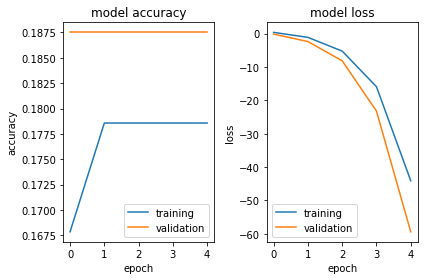

Test loss: -75.3
Test accuracy: 0.104


In [0]:
# Converted this to sequential model

# this is a hyperparameter
D = 20


model = Sequential()
model.add(Input(shape=(T,)))
model.add(Embedding(V + 1, D))
model.add(Conv1D(32, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(128, 3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(data_train, Ytrain, epochs=5, verbose=True, validation_split=.1)
plot_training_history(history, model, data_test, Ytest)

## Trying to fit to the multi-classification model like what we did before

### Convert the data

In [0]:
Y

array([3, 2, 2, 2, 2, 1, 2, 2, 2, 2, 3, 2, 3, 1, 1, 1, 3, 2, 2, 3, 3, 3,
       2, 3, 3, 3, 2, 1, 2, 2, 2, 4, 3, 2, 2, 4, 2, 1, 2, 1, 3, 3, 2, 3,
       3, 3, 3, 2, 3, 1, 3, 3, 4, 4, 2, 1, 2, 2, 4, 3, 4, 4, 3, 2, 2, 1,
       2, 1, 4, 1, 4, 2, 1, 2, 0, 2, 2, 1, 4, 3, 1, 1, 1, 4, 0, 1, 1, 1,
       2, 1, 4, 1, 2, 2, 4, 4, 2, 2, 2, 3, 2, 4, 3, 2, 1, 3, 0, 2, 4, 4,
       1, 0, 3, 0, 2, 1, 3, 0, 2, 3, 4, 2, 2, 3, 4, 4, 1, 2, 3, 3, 2, 3,
       3, 2, 4, 0, 1, 2, 2, 1, 2, 2, 3, 2, 1, 2, 4, 1, 2, 2, 4, 2, 3, 2,
       2, 1, 0, 2, 2, 4, 2, 3, 3, 3, 4, 2, 3, 4, 2, 2, 3, 4, 2, 4, 3, 3,
       3, 4, 2, 4, 4, 2, 2, 4, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 4, 2, 4,
       2, 2, 1, 3, 2, 4, 2, 0, 0, 4, 4, 2, 2, 2, 3, 2, 1, 2, 2, 3, 2, 1,
       4, 2, 2, 2, 4, 2, 3, 4, 2, 2, 1, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 3,
       2, 4, 4, 2, 1, 2, 2, 3, 2, 2, 3, 3, 4, 2, 3, 4, 1, 1, 2, 2, 1, 3,
       2, 3, 2, 1, 2, 2, 2, 2, 3, 1, 2, 1, 2, 2, 2, 2, 3, 1, 3, 2, 3, 2,
       2, 2, 3, 4, 3, 3, 1, 2, 4, 2, 3, 2, 1, 2, 2,

In [0]:
Ytrain

array([3, 2, 2, 2, 2, 3, 2, 2, 0, 4, 2, 3, 4, 2, 2, 2, 2, 4, 4, 2, 2, 2,
       2, 2, 2, 1, 2, 2, 3, 2, 0, 3, 4, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2,
       3, 3, 3, 4, 1, 3, 1, 2, 2, 4, 2, 2, 2, 4, 2, 4, 1, 2, 1, 2, 1, 3,
       2, 2, 1, 4, 1, 3, 3, 0, 2, 4, 4, 4, 2, 4, 4, 2, 2, 3, 3, 3, 0, 2,
       1, 4, 2, 2, 2, 4, 2, 3, 3, 2, 3, 3, 1, 4, 2, 4, 2, 2, 2, 1, 3, 1,
       2, 2, 2, 2, 2, 0, 2, 2, 4, 2, 3, 2, 4, 2, 3, 2, 1, 2, 2, 2, 4, 2,
       2, 3, 2, 4, 2, 3, 4, 2, 4, 2, 3, 1, 3, 3, 2, 3, 1, 1, 2, 4, 4, 2,
       2, 1, 4, 2, 2, 2, 1, 2, 2, 4, 1, 2, 2, 1, 2, 2, 2, 2, 4, 3, 3, 2,
       2, 3, 3, 1, 0, 2, 2, 2, 1, 1, 2, 3, 2, 2, 1, 1, 2, 4, 2, 2, 2, 1,
       2, 2, 2, 2, 4, 2, 2, 2, 2, 3, 1, 3, 4, 4, 1, 2, 3, 1, 1, 2, 3, 1,
       1, 4, 1, 2, 2, 2, 3, 3, 4, 1, 1, 4, 1, 2, 2, 3, 2, 2, 2, 2, 2, 2,
       1, 0, 2, 2, 2, 4, 2, 3, 2, 2, 1, 2, 2, 0, 2, 2, 2, 2, 3, 1, 2, 2,
       2, 2, 4, 3, 2, 2, 2, 1, 2, 4, 4, 4, 2, 2, 3, 2, 4, 2, 3, 1, 0, 0,
       3, 3, 1, 3, 2, 0, 2, 2, 2, 2, 1, 2, 3, 3, 4,

In [0]:
from tensorflow.keras.utils import to_categorical

In [0]:
num_classes = 5
training_labels = to_categorical(Ytrain, num_classes)
test_labels = to_categorical(Ytest, num_classes)

In [0]:
training_labels

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

### Modify to "fit" into the way we've done CNNs for images

Epoch 1/5
56/56 [==============================] - 0s 7ms/step - loss: 1.4322 - accuracy: 0.4964 - val_loss: 1.5064 - val_accuracy: 0.4062
Epoch 2/5
56/56 [==============================] - 0s 5ms/step - loss: 1.3001 - accuracy: 0.5036 - val_loss: 1.5595 - val_accuracy: 0.4062
Epoch 3/5
56/56 [==============================] - 0s 5ms/step - loss: 1.2406 - accuracy: 0.5036 - val_loss: 1.5742 - val_accuracy: 0.4062
Epoch 4/5
56/56 [==============================] - 0s 5ms/step - loss: 1.1189 - accuracy: 0.5036 - val_loss: 1.5365 - val_accuracy: 0.4062
Epoch 5/5
56/56 [==============================] - 0s 5ms/step - loss: 0.9192 - accuracy: 0.5607 - val_loss: 1.5797 - val_accuracy: 0.4375


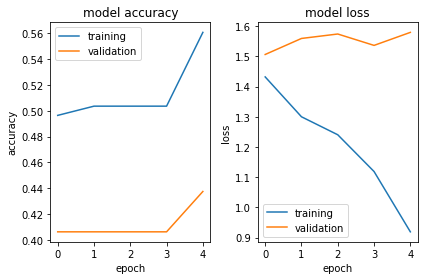

Test loss: 1.51
Test accuracy: 0.496


In [0]:
D = 20

model = Sequential()
model.add(Input(shape=(T,)))
model.add(Embedding(V + 1, D))
model.add(Conv1D(32, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(128, 3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(units=num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(data_train, training_labels, epochs=5, batch_size=5, verbose=True, validation_split=.1)
plot_training_history(history, model, data_test, test_labels)

## Increase size of data set

### Loading Data

Initially I had used JIRA_OPEN_DATA_ALL.csv but that was really way too much data and Colab ran out of RAM. This data set had ~ 200k rows. So I settled for a smaller set which had about 40k rows. This was done by performing the SQL query:

```
select * from jira_issue_report 
where status = 'Closed' and type = 'Bug' and (project = 'FLEX' or project = 'JBIDE' or project = 'RF' or project = 'SPR' or project = 'HBASE') and not (description is null or description = '') and priority is not null
```
Data is originally from https://github.com/marcoortu/jira-social-repository . This is from the paper "The Jira Repository Dataset" by Marco Ortu et al - see https://www.researchgate.net/publication/301370380_The_JIRA_Repository_Dataset


In [0]:
dataset1 = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Octopus2/JIRA_OPEN_DATA_LARGESET.csv")

### Data Preparation

In [0]:
df2 = dataset1[["title", "description", "priority"]]
df2['features'] = df2['title'] + " " + df2['description']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
df2.shape

(41513, 4)

In [0]:
df3 = df2.copy()
df3.features = df3.features.str.replace(r"[\n\r\t]+", " ")
df3.features = df3.features.str.replace(r"([a-zA-Z0-9_\-\.]+)@([a-zA-Z0-9_\-\.]+)\.([a-zA-Z]{2,5})", " ")
df3.features = df3.features.str.replace(r"((http[s]?|ftp):\/)?\/?([^:\/\s]+)((\/\w+)*\/)([\w\-\.]+[^#?\s]+)(.*)?(#[\w\-]+)?", " ")
df3.features = df3.features.str.replace(r"([0-9]+)", " ")

In [0]:
# Added this as it takes a long time to process the 200k lines above
df3.to_csv('/content/gdrive/My Drive/Colab Notebooks/Octopus2/JIRA_OPEN_DATA_LARGESET_PROCESSED.csv')

In [0]:
# Use this instead of reading the raw data and processing from scratch
df3 = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Octopus2/JIRA_OPEN_DATA_LARGESET_PROCESSED.csv')

(array([ 2949.,     0., 21272.,     0., 12550.,     0.,   936.,     0.,
         3657.,   149.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

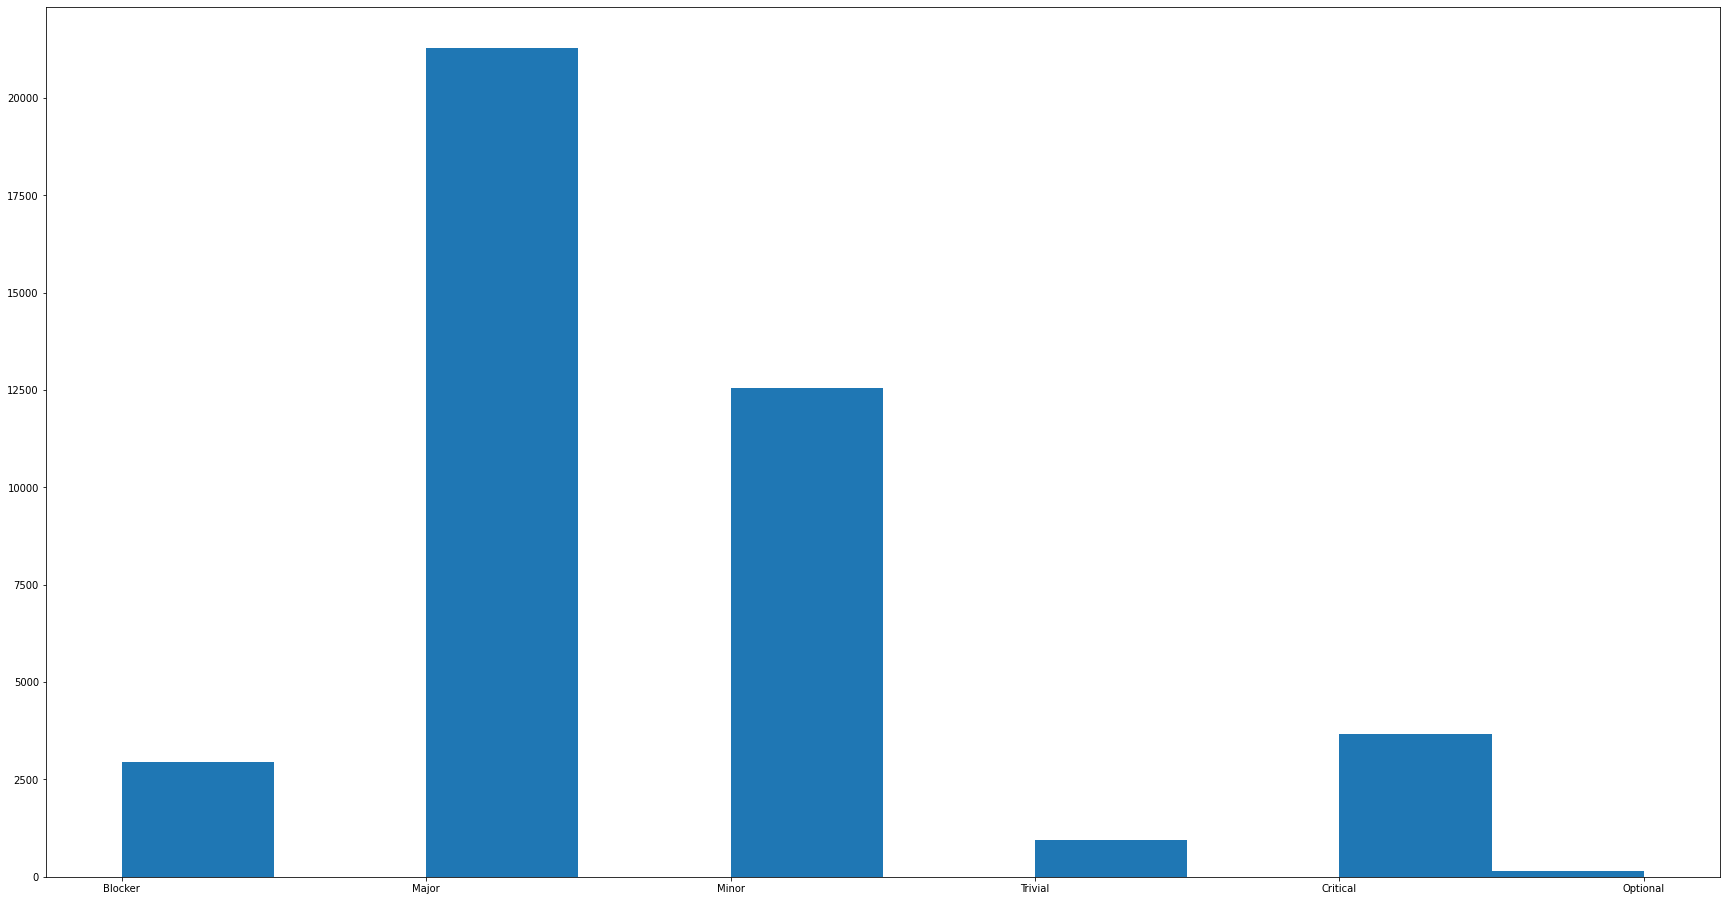

In [7]:
plt.figure(figsize=(30,16))
plt.hist(df3.priority)

In [0]:
df3['labels'] = df3['priority'].map({'Optional': 0, 'Trivial': 1, 'Minor': 2, 'Major': 3, 'Blocker': 4, 'Critical': 5})
Y1 = df3['labels'].values

In [0]:
Y1

array([4, 3, 2, ..., 3, 3, 3])

In [0]:
df_train1, df_test1, Ytrain1, Ytest1 = train_test_split(df3['features'], Y1, test_size=0.3)

In [0]:
# Convert sentences to sequences (one hot encoding)
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train1)
sequences_train = tokenizer.texts_to_sequences(df_train1)
sequences_test = tokenizer.texts_to_sequences(df_test1)

In [12]:
# get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)


Found 48187 unique tokens.


In [13]:
# pad sequences so that we get a N x T matrix
data_train1 = pad_sequences(sequences_train)
print('Shape of data train tensor:', data_train1.shape)

# get sequence length
T = data_train1.shape[1]

Shape of data train tensor: (29059, 9524)


In [14]:
data_test1 = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test tensor:', data_test1.shape)

Shape of data test tensor: (12454, 9524)


In [0]:
from tensorflow.keras.utils import to_categorical

In [0]:
num_classes = 6
training_labels1 = to_categorical(Ytrain1, num_classes)
test_labels1 = to_categorical(Ytest1, num_classes)

### Trying a basic model

Epoch 1/5
205/205 [==============================] - 12s 59ms/step - loss: 1.2445 - accuracy: 0.5063 - val_loss: 1.1577 - val_accuracy: 0.5237
Epoch 2/5
205/205 [==============================] - 12s 57ms/step - loss: 1.1376 - accuracy: 0.5401 - val_loss: 1.1020 - val_accuracy: 0.5595
Epoch 3/5
205/205 [==============================] - 12s 57ms/step - loss: 1.0091 - accuracy: 0.6022 - val_loss: 1.0927 - val_accuracy: 0.5637
Epoch 4/5
205/205 [==============================] - 12s 57ms/step - loss: 0.8733 - accuracy: 0.6574 - val_loss: 1.1798 - val_accuracy: 0.5513
Epoch 5/5
205/205 [==============================] - 12s 57ms/step - loss: 0.7367 - accuracy: 0.7175 - val_loss: 1.3057 - val_accuracy: 0.5502


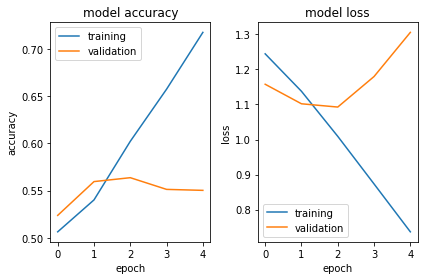

Test loss: 1.3
Test accuracy: 0.547


In [0]:
D = 20

model = Sequential()
model.add(Input(shape=(T,)))
model.add(Embedding(V + 1, D))
model.add(Conv1D(32, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(128, 3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(units=num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(data_train1, training_labels1, epochs=5, batch_size=128, verbose=True, validation_split=.1)
plot_training_history(history, model, data_test1, test_labels1)

### Adding more classification layers

Epoch 1/5
205/205 [==============================] - 12s 58ms/step - loss: 1.2309 - accuracy: 0.5087 - val_loss: 1.1704 - val_accuracy: 0.5237
Epoch 2/5
205/205 [==============================] - 12s 57ms/step - loss: 1.1648 - accuracy: 0.5201 - val_loss: 1.1386 - val_accuracy: 0.5437
Epoch 3/5
205/205 [==============================] - 12s 57ms/step - loss: 1.0451 - accuracy: 0.5654 - val_loss: 1.1957 - val_accuracy: 0.5454
Epoch 4/5
205/205 [==============================] - 12s 57ms/step - loss: 0.8525 - accuracy: 0.6478 - val_loss: 1.2901 - val_accuracy: 0.5017
Epoch 5/5
205/205 [==============================] - 12s 57ms/step - loss: 0.6835 - accuracy: 0.7203 - val_loss: 1.4602 - val_accuracy: 0.4587


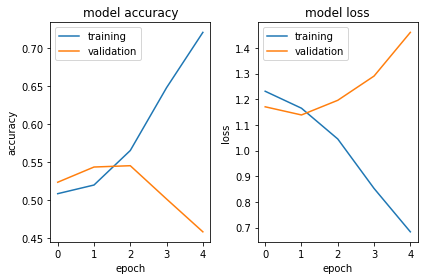

Test loss: 1.51
Test accuracy: 0.456


In [0]:
model = Sequential()
model.add(Input(shape=(T,)))
model.add(Embedding(V + 1, D))
model.add(Conv1D(32, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(128, 3, activation='relu'))
model.add(GlobalMaxPooling1D())

model.add(Dense(units=800, activation='relu'))
model.add(Dense(units=400, activation='relu'))
model.add(Dense(units=200, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(data_train1, training_labels1, epochs=5, batch_size=128, verbose=True, validation_split=.1)
plot_training_history(history, model, data_test1, test_labels1)

### Reduce the batch size 

Epoch 1/5
818/818 [==============================] - 17s 21ms/step - loss: 1.2064 - accuracy: 0.5201 - val_loss: 1.1399 - val_accuracy: 0.5444
Epoch 2/5
818/818 [==============================] - 17s 20ms/step - loss: 1.1509 - accuracy: 0.5332 - val_loss: 1.1446 - val_accuracy: 0.5465
Epoch 3/5
818/818 [==============================] - 17s 20ms/step - loss: 1.0708 - accuracy: 0.5402 - val_loss: 1.1758 - val_accuracy: 0.5396
Epoch 4/5
818/818 [==============================] - 17s 21ms/step - loss: 0.9420 - accuracy: 0.5829 - val_loss: 1.3292 - val_accuracy: 0.4597
Epoch 5/5
818/818 [==============================] - 17s 21ms/step - loss: 0.7992 - accuracy: 0.6539 - val_loss: 1.5062 - val_accuracy: 0.4573


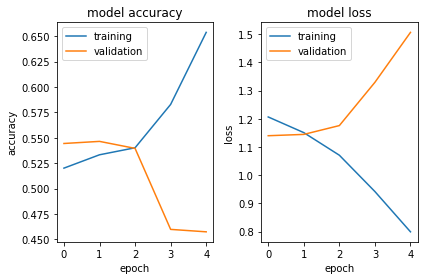

Test loss: 1.56
Test accuracy: 0.456


In [0]:
model = Sequential()
model.add(Input(shape=(T,)))
model.add(Embedding(V + 1, D))
model.add(Conv1D(32, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(128, 3, activation='relu'))
model.add(GlobalMaxPooling1D())

model.add(Dense(units=800, activation='relu'))
model.add(Dense(units=400, activation='relu'))
model.add(Dense(units=200, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(data_train1, training_labels1, epochs=5, batch_size=32, verbose=True, validation_split=.1)
plot_training_history(history, model, data_test1, test_labels1)

### Add Dropout

Epoch 1/5
818/818 [==============================] - 17s 21ms/step - loss: 1.2210 - accuracy: 0.5098 - val_loss: 1.1532 - val_accuracy: 0.5440
Epoch 2/5
818/818 [==============================] - 17s 20ms/step - loss: 1.1641 - accuracy: 0.5318 - val_loss: 1.1425 - val_accuracy: 0.5434
Epoch 3/5
818/818 [==============================] - 17s 21ms/step - loss: 1.0808 - accuracy: 0.5561 - val_loss: 1.1629 - val_accuracy: 0.5458
Epoch 4/5
818/818 [==============================] - 17s 21ms/step - loss: 0.9385 - accuracy: 0.6148 - val_loss: 1.2153 - val_accuracy: 0.4979
Epoch 5/5
818/818 [==============================] - 17s 21ms/step - loss: 0.7900 - accuracy: 0.6750 - val_loss: 1.3893 - val_accuracy: 0.4842


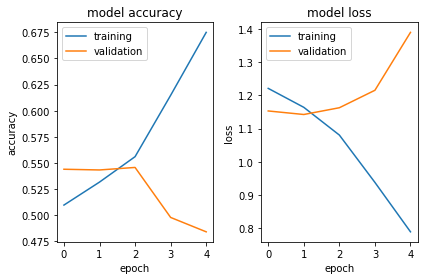

Test loss: 1.41
Test accuracy: 0.488


In [0]:
model = Sequential()
model.add(Input(shape=(T,)))
model.add(Embedding(V + 1, D))
model.add(Conv1D(32, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(128, 3, activation='relu'))
model.add(GlobalMaxPooling1D())

model.add(Dense(units=800, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=400, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=200, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=100, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(data_train1, training_labels1, epochs=5, batch_size=32, verbose=True, validation_split=.1)
plot_training_history(history, model, data_test1, test_labels1)

### Add Batch Norm

Epoch 1/5
818/818 [==============================] - 22s 27ms/step - loss: 1.3359 - accuracy: 0.4830 - val_loss: 1.1566 - val_accuracy: 0.5248
Epoch 2/5
818/818 [==============================] - 21s 26ms/step - loss: 1.1653 - accuracy: 0.5397 - val_loss: 1.1119 - val_accuracy: 0.5664
Epoch 3/5
818/818 [==============================] - 22s 27ms/step - loss: 1.0706 - accuracy: 0.5862 - val_loss: 1.1398 - val_accuracy: 0.5633
Epoch 4/5
818/818 [==============================] - 21s 26ms/step - loss: 0.9735 - accuracy: 0.6305 - val_loss: 1.2482 - val_accuracy: 0.5155
Epoch 5/5
818/818 [==============================] - 21s 26ms/step - loss: 0.8756 - accuracy: 0.6684 - val_loss: 1.1696 - val_accuracy: 0.5568


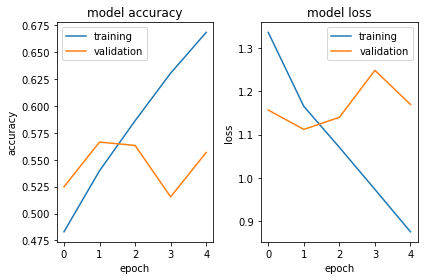

Test loss: 1.21
Test accuracy: 0.547


In [0]:
model = Sequential()
model.add(Input(shape=(T,)))
model.add(Embedding(V + 1, D))
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(3))
model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(3))
model.add(Conv1D(128, 3, activation='relu'))
model.add(BatchNormalization())
model.add(GlobalMaxPooling1D())

model.add(Dense(units=800, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(units=400, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(units=200, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(units=100, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(units=num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(data_train1, training_labels1, epochs=5, batch_size=32, verbose=True, validation_split=.1)
plot_training_history(history, model, data_test1, test_labels1)

### Adding more Conv Layers

Epoch 1/5
818/818 [==============================] - 35s 43ms/step - loss: 1.3470 - accuracy: 0.4837 - val_loss: 1.1527 - val_accuracy: 0.5437
Epoch 2/5
818/818 [==============================] - 35s 43ms/step - loss: 1.2070 - accuracy: 0.5222 - val_loss: 1.1598 - val_accuracy: 0.5396
Epoch 3/5
818/818 [==============================] - 35s 43ms/step - loss: 1.1850 - accuracy: 0.5327 - val_loss: 1.1509 - val_accuracy: 0.5520
Epoch 4/5
818/818 [==============================] - 35s 43ms/step - loss: 1.1511 - accuracy: 0.5429 - val_loss: 1.1333 - val_accuracy: 0.5358
Epoch 5/5
818/818 [==============================] - 35s 43ms/step - loss: 1.0934 - accuracy: 0.5792 - val_loss: 1.1555 - val_accuracy: 0.5451


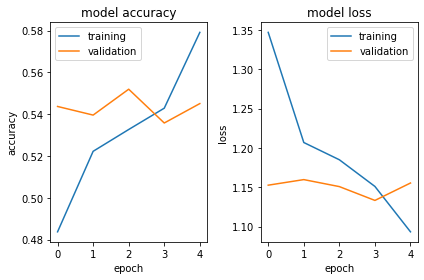

Test loss: 1.2
Test accuracy: 0.548


In [0]:
model = Sequential()
model.add(Input(shape=(T,)))
model.add(Embedding(V + 1, D))
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(3))
model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(3))
model.add(Conv1D(128, 3, activation='relu'))
model.add(BatchNormalization())
model.add(GlobalMaxPooling1D())

model.add(Dense(units=800, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(units=400, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(units=200, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(units=100, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(units=num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(data_train1, training_labels1, epochs=5, batch_size=32, verbose=True, validation_split=.1)
plot_training_history(history, model, data_test1, test_labels1)

### Trying SGD

Epoch 1/5
818/818 [==============================] - 44s 53ms/step - loss: 1.4527 - accuracy: 0.4305 - val_loss: 1.3904 - val_accuracy: 0.5165
Epoch 2/5
818/818 [==============================] - 43s 53ms/step - loss: 1.2587 - accuracy: 0.4939 - val_loss: 11.5269 - val_accuracy: 0.0320
Epoch 3/5
818/818 [==============================] - 43s 53ms/step - loss: 1.2384 - accuracy: 0.5005 - val_loss: 3.3044 - val_accuracy: 0.4377
Epoch 4/5
818/818 [==============================] - 43s 53ms/step - loss: 1.2245 - accuracy: 0.5025 - val_loss: 961.9958 - val_accuracy: 0.1339
Epoch 5/5
818/818 [==============================] - 43s 53ms/step - loss: 1.2102 - accuracy: 0.5125 - val_loss: 3.6019 - val_accuracy: 0.3080


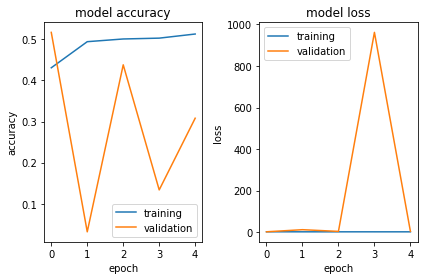

Test loss: 3.68
Test accuracy: 0.308


In [0]:
model = Sequential()
model.add(Input(shape=(T,)))
model.add(Embedding(V + 1, D))
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(3))
model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(3))
model.add(Conv1D(128, 3, activation='relu'))
model.add(BatchNormalization())
model.add(GlobalMaxPooling1D())

model.add(Dense(units=800, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(units=400, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(units=200, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(units=100, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(units=num_classes, activation='softmax'))

model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(data_train1, training_labels1, epochs=5, batch_size=32, verbose=True, validation_split=.1)
plot_training_history(history, model, data_test1, test_labels1)

### Decrease batch size

Epoch 1/5
1635/1635 [==============================] - 44s 27ms/step - loss: 1.3126 - accuracy: 0.4863 - val_loss: 1.1713 - val_accuracy: 0.5330
Epoch 2/5
1635/1635 [==============================] - 44s 27ms/step - loss: 1.2053 - accuracy: 0.5194 - val_loss: 1.1637 - val_accuracy: 0.5255
Epoch 3/5
1635/1635 [==============================] - 45s 27ms/step - loss: 1.1820 - accuracy: 0.5264 - val_loss: 1.1440 - val_accuracy: 0.5427
Epoch 4/5
1635/1635 [==============================] - 45s 28ms/step - loss: 1.1342 - accuracy: 0.5534 - val_loss: 1.1334 - val_accuracy: 0.5616
Epoch 5/5
1635/1635 [==============================] - 45s 27ms/step - loss: 1.0891 - accuracy: 0.5764 - val_loss: 1.1258 - val_accuracy: 0.5526


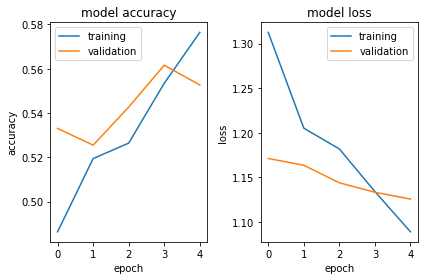

Test loss: 1.13
Test accuracy: 0.56


In [0]:
model = Sequential()
model.add(Input(shape=(T,)))
model.add(Embedding(V + 1, D))
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(3))
model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(3))
model.add(Conv1D(128, 3, activation='relu'))
model.add(BatchNormalization())
model.add(GlobalMaxPooling1D())

model.add(Dense(units=800, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(units=400, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(units=200, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(units=100, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(units=num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(data_train1, training_labels1, epochs=5, batch_size=16, verbose=True, validation_split=.1)
plot_training_history(history, model, data_test1, test_labels1)

### Increase number of epochs

Epoch 1/20
1635/1635 [==============================] - 45s 27ms/step - loss: 1.3059 - accuracy: 0.4874 - val_loss: 1.1827 - val_accuracy: 0.5268
Epoch 2/20
1635/1635 [==============================] - 45s 27ms/step - loss: 1.2079 - accuracy: 0.5185 - val_loss: 1.1689 - val_accuracy: 0.5282
Epoch 3/20
1635/1635 [==============================] - 45s 27ms/step - loss: 1.1882 - accuracy: 0.5223 - val_loss: 1.1613 - val_accuracy: 0.5437
Epoch 4/20
1635/1635 [==============================] - 45s 27ms/step - loss: 1.1679 - accuracy: 0.5329 - val_loss: 1.1347 - val_accuracy: 0.5506
Epoch 5/20
1635/1635 [==============================] - 45s 27ms/step - loss: 1.1247 - accuracy: 0.5543 - val_loss: 1.1123 - val_accuracy: 0.5595
Epoch 6/20
1635/1635 [==============================] - 44s 27ms/step - loss: 1.0682 - accuracy: 0.5877 - val_loss: 1.1189 - val_accuracy: 0.5571
Epoch 7/20
1635/1635 [==============================] - 44s 27ms/step - loss: 1.0123 - accuracy: 0.6146 - val_loss: 1.1836 -

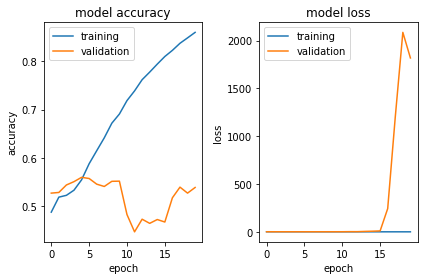

Test loss: 1.69e+03
Test accuracy: 0.535


In [0]:
model = Sequential()
model.add(Input(shape=(T,)))
model.add(Embedding(V + 1, D))
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(3))
model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(3))
model.add(Conv1D(128, 3, activation='relu'))
model.add(BatchNormalization())
model.add(GlobalMaxPooling1D())

model.add(Dense(units=800, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(units=400, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(units=200, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(units=100, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(units=num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(data_train1, training_labels1, epochs=20, batch_size=16, verbose=True, validation_split=.1)
plot_training_history(history, model, data_test1, test_labels1)

### Add more Conv Layers

Epoch 1/20
1635/1635 [==============================] - 61s 37ms/step - loss: 1.3232 - accuracy: 0.4759 - val_loss: 1.1710 - val_accuracy: 0.5409
Epoch 2/20
1635/1635 [==============================] - 60s 37ms/step - loss: 1.2171 - accuracy: 0.5160 - val_loss: 1.1844 - val_accuracy: 0.5375
Epoch 3/20
1635/1635 [==============================] - 60s 37ms/step - loss: 1.2029 - accuracy: 0.5232 - val_loss: 1.2392 - val_accuracy: 0.5392
Epoch 4/20
1635/1635 [==============================] - 60s 37ms/step - loss: 1.1959 - accuracy: 0.5277 - val_loss: 1.1637 - val_accuracy: 0.5403
Epoch 5/20
1635/1635 [==============================] - 60s 37ms/step - loss: 1.1879 - accuracy: 0.5295 - val_loss: 1.5278 - val_accuracy: 0.4955
Epoch 6/20
1635/1635 [==============================] - 60s 37ms/step - loss: 1.1698 - accuracy: 0.5345 - val_loss: 1.5686 - val_accuracy: 0.4855
Epoch 7/20
1635/1635 [==============================] - 60s 37ms/step - loss: 1.1293 - accuracy: 0.5534 - val_loss: 1.1775 -

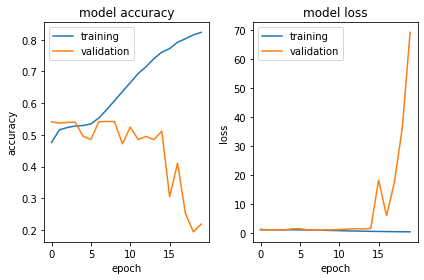

Test loss: 67.4
Test accuracy: 0.211


In [0]:
model = Sequential()
model.add(Input(shape=(T,)))
model.add(Embedding(V + 1, D))
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(3))

model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(3))

model.add(Conv1D(128, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(128, 3, activation='relu'))
model.add(BatchNormalization())
model.add(GlobalMaxPooling1D())

model.add(Dense(units=800, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(units=400, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(units=200, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(units=100, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(units=num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(data_train1, training_labels1, epochs=20, batch_size=16, verbose=True, validation_split=.1)
plot_training_history(history, model, data_test1, test_labels1)

### Reduce Batch Size

Epoch 1/20
3270/3270 [==============================] - 87s 27ms/step - loss: 1.2970 - accuracy: 0.4819 - val_loss: 1.3093 - val_accuracy: 0.5344
Epoch 2/20
3270/3270 [==============================] - 86s 26ms/step - loss: 1.2165 - accuracy: 0.5116 - val_loss: 1.1600 - val_accuracy: 0.5423
Epoch 3/20
3270/3270 [==============================] - 86s 26ms/step - loss: 1.2076 - accuracy: 0.5139 - val_loss: 1.2378 - val_accuracy: 0.4756
Epoch 4/20
3270/3270 [==============================] - 87s 27ms/step - loss: 1.1998 - accuracy: 0.5183 - val_loss: 1.2587 - val_accuracy: 0.5045
Epoch 5/20
3270/3270 [==============================] - 86s 26ms/step - loss: 1.1951 - accuracy: 0.5212 - val_loss: 2.0156 - val_accuracy: 0.3503
Epoch 6/20
3270/3270 [==============================] - 86s 26ms/step - loss: 1.1816 - accuracy: 0.5277 - val_loss: 1.4019 - val_accuracy: 0.4112
Epoch 7/20
3270/3270 [==============================] - 86s 26ms/step - loss: 1.1581 - accuracy: 0.5402 - val_loss: 12.2635 

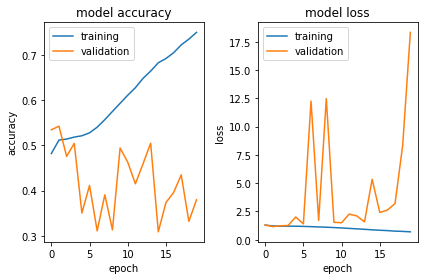

Test loss: 18.7
Test accuracy: 0.383


In [0]:
model = Sequential()
model.add(Input(shape=(T,)))
model.add(Embedding(V + 1, D))
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(3))

model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(3))

model.add(Conv1D(128, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(128, 3, activation='relu'))
model.add(BatchNormalization())
model.add(GlobalMaxPooling1D())

model.add(Dense(units=800, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(units=400, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(units=200, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(units=100, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(units=num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(data_train1, training_labels1, epochs=20, batch_size=8, verbose=True, validation_split=.1)
plot_training_history(history, model, data_test1, test_labels1)

### Try with increased validation size

Epoch 1/20
2906/2906 [==============================] - 80s 27ms/step - loss: 1.3082 - accuracy: 0.4731 - val_loss: 1.1957 - val_accuracy: 0.5404
Epoch 2/20
2906/2906 [==============================] - 79s 27ms/step - loss: 1.2184 - accuracy: 0.5140 - val_loss: 1.1725 - val_accuracy: 0.5439
Epoch 3/20
2906/2906 [==============================] - 78s 27ms/step - loss: 1.2105 - accuracy: 0.5115 - val_loss: 1.1726 - val_accuracy: 0.5439
Epoch 4/20
2906/2906 [==============================] - 77s 27ms/step - loss: 1.2193 - accuracy: 0.5045 - val_loss: 1.1966 - val_accuracy: 0.5091
Epoch 5/20
2906/2906 [==============================] - 78s 27ms/step - loss: 1.2027 - accuracy: 0.5181 - val_loss: 1.2196 - val_accuracy: 0.4702
Epoch 6/20
2906/2906 [==============================] - 79s 27ms/step - loss: 1.1920 - accuracy: 0.5221 - val_loss: 1.1649 - val_accuracy: 0.5480
Epoch 7/20
2906/2906 [==============================] - 79s 27ms/step - loss: 1.1720 - accuracy: 0.5301 - val_loss: 739.1569

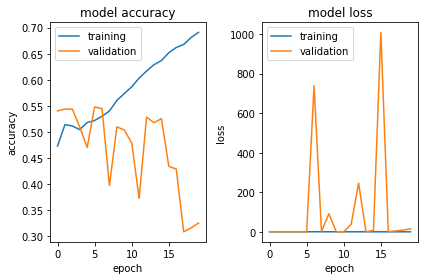

Test loss: 32.7
Test accuracy: 0.321


In [0]:
model = Sequential()
model.add(Input(shape=(T,)))
model.add(Embedding(V + 1, D))
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(3))

model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(3))

model.add(Conv1D(128, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(128, 3, activation='relu'))
model.add(BatchNormalization())
model.add(GlobalMaxPooling1D())

model.add(Dense(units=800, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(units=400, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(units=200, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(units=100, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(units=num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(data_train1, training_labels1, epochs=20, batch_size=8, verbose=True, validation_split=.2)
plot_training_history(history, model, data_test1, test_labels1)

### Increased dropout

Epoch 1/20
2906/2906 [==============================] - 95s 33ms/step - loss: 1.3266 - accuracy: 0.4741 - val_loss: 1.2331 - val_accuracy: 0.5289
Epoch 2/20
2906/2906 [==============================] - 94s 32ms/step - loss: 1.2110 - accuracy: 0.5165 - val_loss: 1.2150 - val_accuracy: 0.5351
Epoch 3/20
2906/2906 [==============================] - 94s 32ms/step - loss: 1.2014 - accuracy: 0.5184 - val_loss: 1.2421 - val_accuracy: 0.4917
Epoch 4/20
2906/2906 [==============================] - 96s 33ms/step - loss: 1.1958 - accuracy: 0.5221 - val_loss: 1.1946 - val_accuracy: 0.5136
Epoch 5/20
2906/2906 [==============================] - 95s 33ms/step - loss: 1.1963 - accuracy: 0.5185 - val_loss: 125.4782 - val_accuracy: 0.5083
Epoch 6/20
2906/2906 [==============================] - 95s 33ms/step - loss: 1.1930 - accuracy: 0.5199 - val_loss: 155407.3125 - val_accuracy: 0.5241
Epoch 7/20
2906/2906 [==============================] - 95s 33ms/step - loss: 1.1902 - accuracy: 0.5237 - val_loss: 5

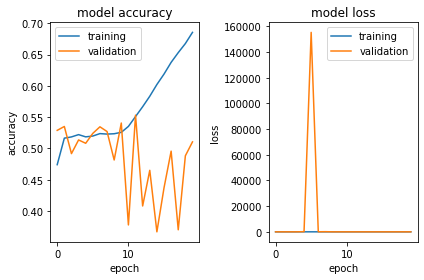

Test loss: 1.63
Test accuracy: 0.494


In [0]:
D = 20

model = Sequential()
model.add(Input(shape=(T,)))
model.add(Embedding(V + 1, D))
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(3))

model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(3))

model.add(Conv1D(128, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(128, 3, activation='relu'))
model.add(BatchNormalization())
model.add(GlobalMaxPooling1D())

model.add(Dense(units=800, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(units=400, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(units=200, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(units=100, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(units=num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(data_train1, training_labels1, epochs=20, batch_size=8, verbose=True, validation_split=.2)
plot_training_history(history, model, data_test1, test_labels1)

In [0]:
name_labels = [
    'Optional',
    'Trivial',
    'Minor',
    'Major',
    'Blocker',
    'Critical'
]

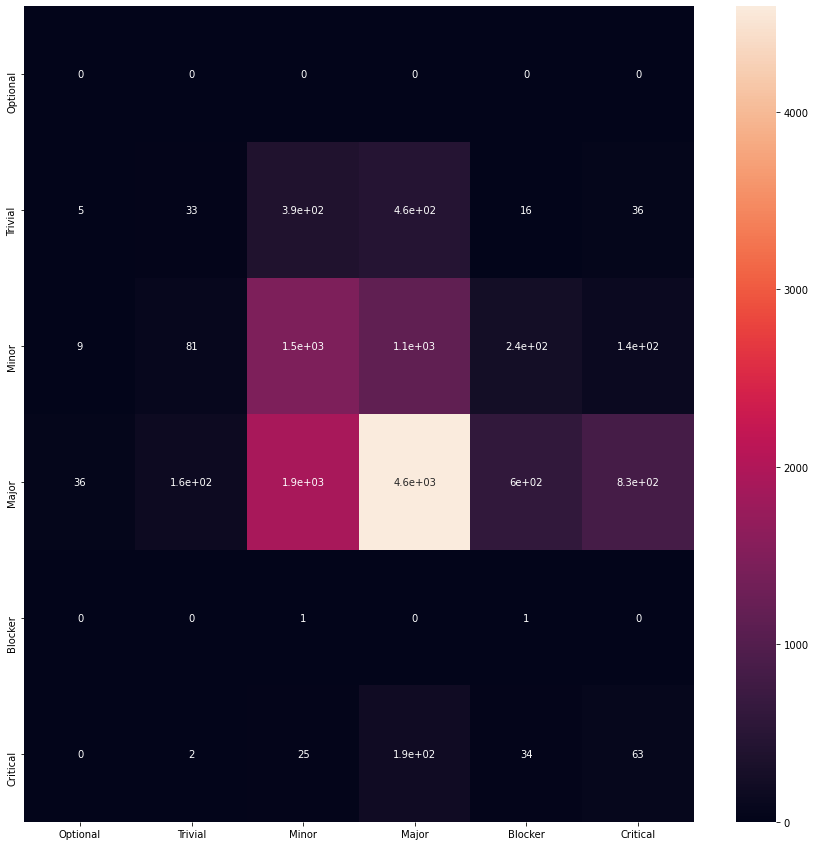

In [0]:
# When did our evaluator do poorly?
predictions = model.predict(data_test1)
cm = confusion_matrix(np.argmax(predictions, axis=1), np.argmax(test_labels1, axis=1))
plt.figure(figsize = (15, 15))

sn.heatmap(cm, annot=True, xticklabels=name_labels, yticklabels=name_labels)
plt.show()

In [21]:
name_labels

['Optional', 'Trivial', 'Minor', 'Major', 'Blocker', 'Critical']

([<matplotlib.axis.XTick at 0x7f125f988470>,
 [Text(0, 0, 'Optional'),
  Text(0, 0, 'Trivial'),
  Text(0, 0, 'Minor'),
  Text(0, 0, 'Major'),
  Text(0, 0, 'Blocker'),
  Text(0, 0, 'Critical')])

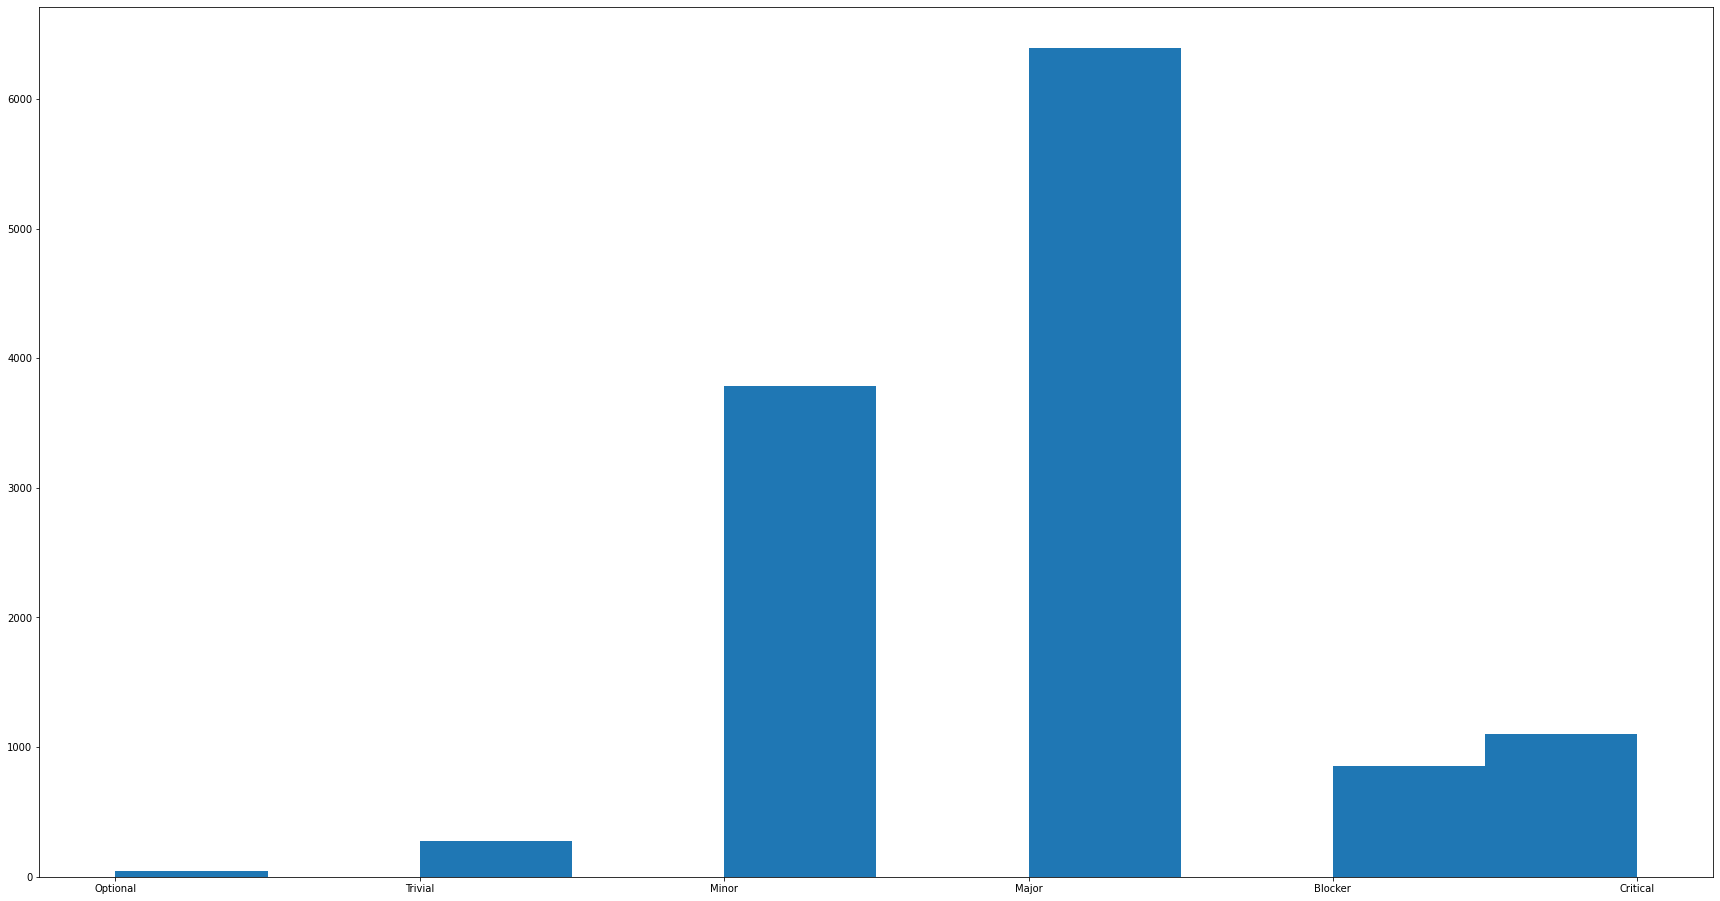

In [23]:
plt.figure(figsize=(30,16))
plt.hist(Ytest1)
plt.xticks(labels=name_labels, ticks=[0,1,2,3,4,5])

### Increase D

Epoch 1/20
2906/2906 [==============================] - 107s 37ms/step - loss: 1.3323 - accuracy: 0.4667 - val_loss: 1.2519 - val_accuracy: 0.5122
Epoch 2/20
2906/2906 [==============================] - 106s 37ms/step - loss: 1.2105 - accuracy: 0.5192 - val_loss: 1.2743 - val_accuracy: 0.3183
Epoch 3/20
2906/2906 [==============================] - 107s 37ms/step - loss: 1.2094 - accuracy: 0.5183 - val_loss: 1.8017 - val_accuracy: 0.3562
Epoch 4/20
2906/2906 [==============================] - 107s 37ms/step - loss: 1.2138 - accuracy: 0.5083 - val_loss: 1.2194 - val_accuracy: 0.5150
Epoch 5/20
2906/2906 [==============================] - 106s 37ms/step - loss: 1.1938 - accuracy: 0.5194 - val_loss: 1.2028 - val_accuracy: 0.5354
Epoch 6/20
2906/2906 [==============================] - 109s 37ms/step - loss: 1.1892 - accuracy: 0.5237 - val_loss: 2.9177 - val_accuracy: 0.3512
Epoch 7/20
2906/2906 [==============================] - 107s 37ms/step - loss: 1.1743 - accuracy: 0.5242 - val_loss: 1

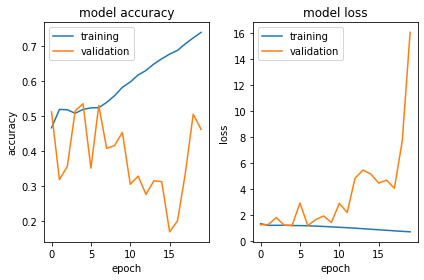

Test loss: 15.6
Test accuracy: 0.464


In [24]:
D = 40

model = Sequential()
model.add(Input(shape=(T,)))
model.add(Embedding(V + 1, D))
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(3))

model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(3))

model.add(Conv1D(128, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(128, 3, activation='relu'))
model.add(BatchNormalization())
model.add(GlobalMaxPooling1D())

model.add(Dense(units=800, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(units=400, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(units=200, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(units=100, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(units=num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(data_train1, training_labels1, epochs=20, batch_size=8, verbose=True, validation_split=.2)
plot_training_history(history, model, data_test1, test_labels1)

### Decrease D

Epoch 1/20
2906/2906 [==============================] - 83s 29ms/step - loss: 1.3393 - accuracy: 0.4654 - val_loss: 1.2106 - val_accuracy: 0.5155
Epoch 2/20
2906/2906 [==============================] - 83s 29ms/step - loss: 1.2097 - accuracy: 0.5180 - val_loss: 1.2083 - val_accuracy: 0.5336
Epoch 3/20
2906/2906 [==============================] - 83s 28ms/step - loss: 1.2050 - accuracy: 0.5161 - val_loss: 1.2469 - val_accuracy: 0.5291
Epoch 4/20
2906/2906 [==============================] - 83s 28ms/step - loss: 1.1953 - accuracy: 0.5203 - val_loss: 2.2797 - val_accuracy: 0.4830
Epoch 5/20
2906/2906 [==============================] - 83s 28ms/step - loss: 1.1905 - accuracy: 0.5255 - val_loss: 101.7560 - val_accuracy: 0.1659
Epoch 6/20
2906/2906 [==============================] - 82s 28ms/step - loss: 1.1840 - accuracy: 0.5259 - val_loss: 266.1588 - val_accuracy: 0.2999
Epoch 7/20
2906/2906 [==============================] - 82s 28ms/step - loss: 1.1776 - accuracy: 0.5236 - val_loss: 8.03

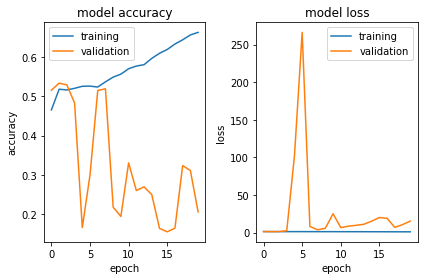

Test loss: 14.8
Test accuracy: 0.201


In [25]:
D = 10

model = Sequential()
model.add(Input(shape=(T,)))
model.add(Embedding(V + 1, D))
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(3))

model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(3))

model.add(Conv1D(128, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(128, 3, activation='relu'))
model.add(BatchNormalization())
model.add(GlobalMaxPooling1D())

model.add(Dense(units=800, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(units=400, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(units=200, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(units=100, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(units=num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(data_train1, training_labels1, epochs=20, batch_size=8, verbose=True, validation_split=.2)
plot_training_history(history, model, data_test1, test_labels1)

In [41]:
model_predict = model.predict_classes(data_test1)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [46]:
print(metrics.classification_report(Ytest1, model_predict, target_names=name_labels))

              precision    recall  f1-score   support

    Optional       0.00      0.00      0.00        47
     Trivial       0.00      0.00      0.00       274
       Minor       0.58      0.01      0.02      3788
       Major       0.45      0.24      0.31      6389
     Blocker       0.07      0.02      0.03       851
    Critical       0.11      0.85      0.19      1105

    accuracy                           0.20     12454
   macro avg       0.20      0.19      0.09     12454
weighted avg       0.42      0.20      0.18     12454



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Add early stopping, revert D to 20

Epoch 1/40
2906/2906 [==============================] - 89s 31ms/step - loss: 1.3382 - accuracy: 0.4697 - val_loss: 1.2801 - val_accuracy: 0.4993
Epoch 2/40
2906/2906 [==============================] - 90s 31ms/step - loss: 1.2135 - accuracy: 0.5162 - val_loss: 1.3265 - val_accuracy: 0.5327
Epoch 3/40
2906/2906 [==============================] - 89s 31ms/step - loss: 1.2119 - accuracy: 0.5117 - val_loss: 1.2781 - val_accuracy: 0.3864
Epoch 4/40
2906/2906 [==============================] - 89s 31ms/step - loss: 1.2104 - accuracy: 0.5091 - val_loss: 4.6507 - val_accuracy: 0.4890
Epoch 5/40
2906/2906 [==============================] - 91s 31ms/step - loss: 1.2040 - accuracy: 0.5130 - val_loss: 16.4309 - val_accuracy: 0.4400
Epoch 6/40
2906/2906 [==============================] - 89s 31ms/step - loss: 1.1843 - accuracy: 0.5263 - val_loss: 1.2416 - val_accuracy: 0.5132
Epoch 7/40
2906/2906 [==============================] - 89s 31ms/step - loss: 1.1473 - accuracy: 0.5551 - val_loss: 1.6625 

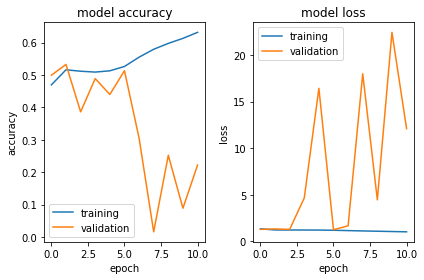

Test loss: 1.22
Test accuracy: 0.522


In [48]:
D = 20

early_stopper = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model = Sequential()
model.add(Input(shape=(T,)))
model.add(Embedding(V + 1, D))
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(3))

model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(3))

model.add(Conv1D(128, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(128, 3, activation='relu'))
model.add(BatchNormalization())
model.add(GlobalMaxPooling1D())

model.add(Dense(units=800, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(units=400, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(units=200, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(units=100, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(units=num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(data_train1, training_labels1, epochs=40, batch_size=8, verbose=True, validation_split=.2, callbacks=[early_stopper])
plot_training_history(history, model, data_test1, test_labels1)

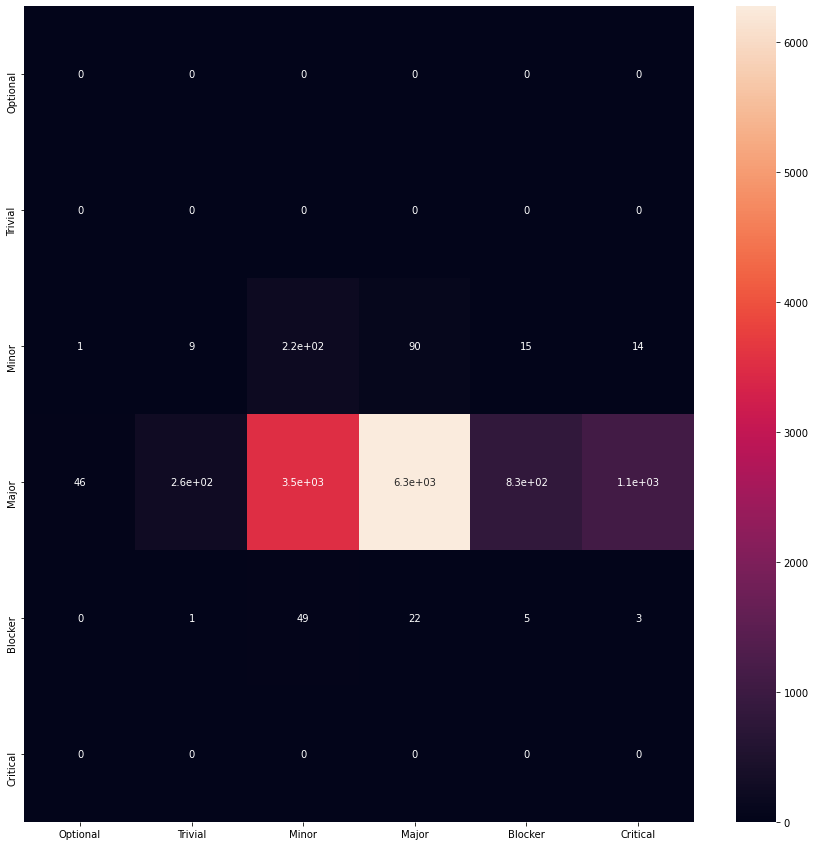

In [49]:
predictions = model.predict(data_test1)
cm = confusion_matrix(np.argmax(predictions, axis=1), np.argmax(test_labels1, axis=1))
plt.figure(figsize = (15, 15))

sn.heatmap(cm, annot=True, xticklabels=name_labels, yticklabels=name_labels)
plt.show()

In [50]:
model_predict = model.predict_classes(data_test1)
print(metrics.classification_report(Ytest1, model_predict, target_names=name_labels))

              precision    recall  f1-score   support

    Optional       0.00      0.00      0.00        47
     Trivial       0.00      0.00      0.00       274
       Minor       0.63      0.06      0.10      3788
       Major       0.52      0.98      0.68      6389
     Blocker       0.06      0.01      0.01       851
    Critical       0.00      0.00      0.00      1105

    accuracy                           0.52     12454
   macro avg       0.20      0.17      0.13     12454
weighted avg       0.46      0.52      0.38     12454



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Adding Class Weight

In [0]:
total_wt = df3.priority.size

In [18]:
name_labels

['Optional', 'Trivial', 'Minor', 'Major', 'Blocker', 'Critical']

In [0]:
optional_wt = df3.loc[df3.priority == 'Optional'].size / total_wt
trivial_wt = df3.loc[df3.priority == 'Trivial'].size / total_wt
minor_wt = df3.loc[df3.priority == 'Minor'].size / total_wt
major_wt = df3.loc[df3.priority == 'Major'].size / total_wt
blocker_wt = df3.loc[df3.priority == 'Blocker'].size / total_wt
critical_wt = df3.loc[df3.priority == 'Critical'].size / total_wt

Epoch 1/40
2906/2906 [==============================] - 103s 35ms/step - loss: 1.8669 - accuracy: 0.4908 - val_loss: 1.5084 - val_accuracy: 0.5153
Epoch 2/40
2906/2906 [==============================] - 103s 35ms/step - loss: 1.6463 - accuracy: 0.5113 - val_loss: 1.5487 - val_accuracy: 0.5148
Epoch 3/40
2906/2906 [==============================] - 102s 35ms/step - loss: 1.6180 - accuracy: 0.5135 - val_loss: 1.4040 - val_accuracy: 0.5160
Epoch 4/40
2906/2906 [==============================] - 102s 35ms/step - loss: 1.5965 - accuracy: 0.5151 - val_loss: 1.4619 - val_accuracy: 0.5299
Epoch 5/40
2906/2906 [==============================] - 102s 35ms/step - loss: 1.5688 - accuracy: 0.5160 - val_loss: 1.3510 - val_accuracy: 0.5181
Epoch 6/40
2906/2906 [==============================] - 103s 35ms/step - loss: 1.5221 - accuracy: 0.5339 - val_loss: 1.3698 - val_accuracy: 0.5243
Epoch 7/40
2906/2906 [==============================] - 102s 35ms/step - loss: 1.4682 - accuracy: 0.5550 - val_loss: 1

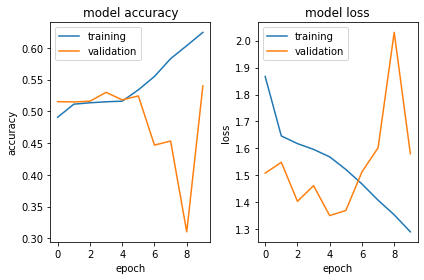

Test loss: 1.35
Test accuracy: 0.517


In [32]:
D = 20

early_stopper = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model = Sequential()
model.add(Input(shape=(T,)))
model.add(Embedding(V + 1, D))
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(3))

model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(3))

model.add(Conv1D(128, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(128, 3, activation='relu'))
model.add(BatchNormalization())
model.add(GlobalMaxPooling1D())

model.add(Dense(units=800, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(units=400, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(units=200, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(units=100, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(units=num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(data_train1, training_labels1, epochs=40, batch_size=8, verbose=True, 
                    validation_split=.2, callbacks=[early_stopper], 
                    class_weight={0: optional_wt, 1: trivial_wt, 2: minor_wt, 3: major_wt, 4: blocker_wt, 5: critical_wt})
plot_training_history(history, model, data_test1, test_labels1)

## Conclusion

In the end, I settled on the "Add early stopping, revert D to 20" model.

Overall the resulting model is not bad and pretty usable even though the accuracy is only ~ 52%. Take a look at the confusion matrix and precision/recall metrics, you will notice the following:


1.   Precision for Major tickets is 52%
2.   Precision for Minor tickets is 63%
3.   If your ticket is Blocker/Critical there is some possibility it will get classified as lower than Minor - but that's ok (I'll explain why later)
4.   If your ticket is Minor, there's a decent probability it will get classified as Major
5.   If your ticket is Optional or Trivial, there's some probability of it being classified as Major

One key insight into the domain is this: when a ticket is created and is Major, Blocker or Critical, it is usually already marked as that by the person filing the ticket on the onset (eg. app crashed, page does not load). It is usually those tickets that are unknown in the beginning that makes sense for the classifier to classify them as Minor or Major. If it is classified as Major but it should be Minor, Optional or Trivial, they will definitely get downgrade them during bug triage. 

